In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

#Machine Learning imports 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import svm
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV, Lasso, RandomizedLasso
from sklearn.cluster import KMeans

from minepy import MINE
from scipy.stats import boxcox

from sklearn.cross_validation import train_test_split
from sklearn import metrics

from sklearn.cross_validation import cross_val_score
from sklearn.feature_selection import RFE

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing
from sklearn.decomposition import PCA
from scipy.stats import skew

/home/raunaq/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv("ad_org_train.csv")
test = pd.read_csv("ad_org_test.csv")
train.head()

,vidid,adview,views,likes,dislikes,comment,published,duration,category
0,VID_18655,40,1031602,8523,363,1095,2016-09-14,PT7M37S,F
1,VID_14135,2,1707,56,2,6,2016-10-01,PT9M30S,D
2,VID_2187,1,2023,25,0,2,2016-07-02,PT2M16S,C
3,VID_23096,6,620860,777,161,153,2016-07-27,PT4M22S,H
4,VID_10175,1,666,1,0,0,2016-06-29,PT31S,D


In [3]:
columns = ['views', 'likes', 'dislikes', 'comment']
for column in columns:
        train[column] = train[column].apply(pd.to_numeric, errors = 'coerce')
        test[column] = test[column].apply(pd.to_numeric, errors = 'coerce')        
        print (column, train[column].isnull().sum())
        print (column, test[column].isnull().sum())

views 2
views 1
likes 155
likes 88
dislikes 155
dislikes 88
comment 233
comment 151


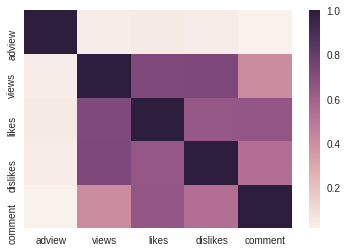

In [4]:
sns.heatmap(train.corr())

In [5]:
train.dropna(inplace=True)
test.dropna(inplace=True)

In [6]:
def time_transform(data):
    duration = data['duration']
    h_pos = 0
    m_pos = 0
    s_pos = len(duration) - 1
    time = 0
    #duration = list(duration)
    if 'H' in duration:
        for i in range(2,len(duration)):
            if duration[i] == 'H':
                h_pos = i
                break
        time = int(duration[2:h_pos]) * 3600 

    if 'M' in duration:
        for i in range(2,len(duration)):
            if duration[i] == 'M':
                m_pos = i
                break
        if 'H' in duration:
            time = time + int(duration[h_pos+1:m_pos]) * 60
        else:
            time = int(duration[2:m_pos]) * 60
        
        if 'S' in duration:
            time = time + int(duration[m_pos+1:s_pos])
        
    else:
        if 'H' not in duration:
            time = time + int(duration[2:s_pos])
        else:
            time = time + int(duration[h_pos+1:s_pos])
    #print (duration, m_pos)
    #time = str(time)
    #print (time)
    data['duration'] = time
    data.head()
    return data

train = train.apply(time_transform, axis=1)
test = test.apply(time_transform, axis=1)

## Creating Bins

In [1291]:
train.loc[train.adview == 1].shape

(6245, 9)

In [1292]:
#Dividing data to adview < 6 and adview > 6 (75th percentile)
temp_adview = train.loc[train.adview >= 6]
train = train.loc[train.adview < 6]

In [1293]:
bins = [0,1,2,3,4,5]
group_names = ['1','2','3','4','5']
#group_names = ['01','12','24','46','6-10','10-1000','10-20K', '>20k']
#bins = bins + [train.adview.max()]
print (bins)

[0, 1, 2, 3, 4, 5]


In [1294]:
categories = pd.cut(train['adview'], bins, labels=group_names, include_lowest=True)
train['adview'] = pd.cut(train['adview'], bins, labels=group_names, include_lowest=True)
categories.head()

1    2
2    1
4    1
5    4
7    1
Name: adview, dtype: category
Categories (5, object): [1 < 2 < 3 < 4 < 5]

In [1295]:
categories.value_counts()

1    6245
2    2184
3    1083
4     749
5     494
Name: adview, dtype: int64

##### Removing

In [816]:
train.describe()

,adview,views,likes,dislikes,comment,duration
count,1.463700e+04,1.463700e+04,14637.000000,14637.000000,14637.000000,14637.000000
mean,2.066030e+03,7.112280e+05,2785.841293,254.429391,409.135547,1040.179067
std,5.282706e+04,2.731475e+06,8938.490736,1029.774864,1511.176934,2316.818747
min,1.000000e+00,4.900000e+01,0.000000,0.000000,0.000000,0.000000
25%,1.000000e+00,3.151700e+04,88.000000,7.000000,7.000000,187.000000
50%,2.000000e+00,1.586680e+05,450.000000,38.000000,46.000000,325.000000
75%,6.000000e+00,5.836130e+05,1863.000000,167.000000,224.000000,723.000000
max,5.429665e+06,1.380479e+08,283824.000000,49449.000000,75045.000000,42317.000000


In [817]:
train.views.quantile(0.99)

7857055.319999995

In [818]:
columns = ['views', 'likes', 'dislikes', 'comment']

def remover(x):
    if x > temp.views.quantile(0.99):
        x = train.views.mean()
temp = train.loc[train.adview <= 10]    
temp.views.map(remover)
#train = temp + train.loc[train.adview > 10]
train.head()
temp.head()

In [204]:
train.query('adview <= 10').query('views > views.quantile(0.99)').views = train.views.mean()
train.query('adview <= 10').query('likes > likes.quantile(0.99)').likes = train.likes.mean()
train.query('adview <= 10').query('dislikes > dislikes.quantile(0.99)').dislikes = train.dislikes.mean()
train.query('adview <= 10').query('comment > comment.quantile(0.99)').comment = train.comment.mean()

In [1339]:
#Dividing data to adview < 6 and adview > 6 (75th percentile)
temp_adview = train.loc[train.adview >= 6]
train = train.loc[train.adview < 6]

In [1340]:
train.shape

(10755, 9)

### Dummies

In [1422]:
dummies = pd.get_dummies(train.category)
train = train.join(dummies)
test = test.join(dummies)

In [1423]:
train.drop(['category'], axis=1,inplace=True)
test.drop(['category'],axis=1, inplace=True)
train.head()

,vidid,adview,views,likes,dislikes,comment,published,duration,A,B,C,D,E,F,G,H
0,VID_18655,40,1031602.0,8523.0,363.0,1095.0,2016-09-14,457,0,0,0,0,0,1,0,0
1,VID_14135,2,1707.0,56.0,2.0,6.0,2016-10-01,570,0,0,0,1,0,0,0,0
2,VID_2187,1,2023.0,25.0,0.0,2.0,2016-07-02,136,0,0,1,0,0,0,0,0
3,VID_23096,6,620860.0,777.0,161.0,153.0,2016-07-27,262,0,0,0,0,0,0,0,1
4,VID_10175,1,666.0,1.0,0.0,0.0,2016-06-29,31,0,0,0,1,0,0,0,0


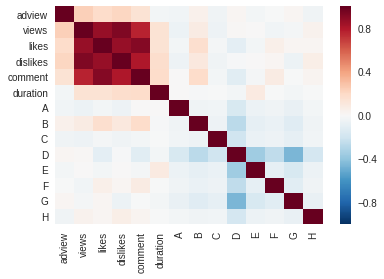

In [1378]:
sns.heatmap(train.corr(method='spearman'))

lbl = preprocessing.LabelEncoder()
lbl.fit(list(train['category'].values))
train['category'] = lbl.transform(list(train['category'].values))
test['category'] = lbl.transform(list(test['category'].values))

In [1424]:
train['published'] = pd.to_datetime(train['published'])
test['published'] = pd.to_datetime(test['published'])

train['dayofweek'] = train.published.dt.dayofweek
test['dayofweek'] = test.published.dt.dayofweek
#quarter didn't work
#weekofyear didn't work

train['year'] = train.published.dt.year
test['year'] = test.published.dt.year

train['month'] = train.published.dt.month
test['month'] = test.published.dt.month

train.drop(['published'], axis=1, inplace=True)
test.drop(['published'], axis=1, inplace=True)

In [1425]:
test.drop(['vidid'], axis=1, inplace=True)
train.drop(['vidid'], axis=1, inplace=True)

In [1426]:
train.head()

,adview,views,likes,dislikes,comment,duration,A,B,C,D,E,F,G,H,dayofweek,year,month
0,40,1031602.0,8523.0,363.0,1095.0,457,0,0,0,0,0,1,0,0,2,2016,9
1,2,1707.0,56.0,2.0,6.0,570,0,0,0,1,0,0,0,0,5,2016,10
2,1,2023.0,25.0,0.0,2.0,136,0,0,1,0,0,0,0,0,5,2016,7
3,6,620860.0,777.0,161.0,153.0,262,0,0,0,0,0,0,0,1,2,2016,7
4,1,666.0,1.0,0.0,0.0,31,0,0,0,1,0,0,0,0,2,2016,6


#### Removing outliers

In [1427]:
train.shape

(14637, 17)

In [7]:
train = train.loc[train.adview < 2000000]

In [8]:
# This value is probably important
#train = train.loc[train.views < 100000000 ]

In [9]:
#train = train.loc[train.comment < 60000]

In [10]:
#print (X_test.iloc[X_test.index == 1742])
#print (X_test.iloc[X_test.index == 1884])
#print (X_test.iloc[X_test.index == 1198])
train.iloc[train.index == 1742]
train = train[train.index != 1742]
train = train[train.index != 1884]
train = train[train.index != 1198]

In [11]:
#train = train.loc[train.dislikes < 40000]

In [1388]:
train.loc[train.comment > 30000]

,adview,views,likes,dislikes,comment,duration,A,B,C,D,E,F,G,H,dayofweek,year,month
965,7,4426961.0,177473.0,3315.0,31165.0,448,0,0,0,1,0,0,0,0,1,2016,2
3000,58,138047869.0,283824.0,15626.0,32271.0,273,0,0,0,0,0,0,1,0,1,2016,10
8275,39,60013005.0,159808.0,35340.0,36336.0,278,0,0,0,1,0,0,0,0,0,2009,6
10372,76,23301541.0,122028.0,14868.0,32060.0,937,0,0,0,1,0,0,0,0,1,2016,5
13141,39,10607744.0,121157.0,3973.0,75045.0,255,0,0,0,0,0,0,1,0,4,2016,6


In [1389]:
train.loc[train.duration > 20000]

,adview,views,likes,dislikes,comment,duration,A,B,C,D,E,F,G,H,dayofweek,year,month
656,3,504577.0,3956.0,129.0,1483.0,36032,0,0,0,0,0,0,1,0,4,2013,1
1126,1,234343.0,310.0,49.0,52.0,42317,0,0,0,0,0,0,1,0,2,2015,6
2351,1,115817.0,496.0,73.0,32.0,22565,0,0,0,1,0,0,0,0,4,2016,9
2730,24,831160.0,1764.0,443.0,224.0,24537,0,0,0,0,0,0,1,0,0,2014,9
3053,1,81703.0,194.0,30.0,49.0,27126,0,0,0,0,0,0,1,0,1,2015,5
4774,1,168556.0,1143.0,37.0,441.0,36018,0,0,0,0,0,0,1,0,1,2012,10
4848,2,232437.0,1775.0,83.0,538.0,36165,0,0,0,0,0,0,1,0,3,2012,11
5558,1,49633.0,189.0,16.0,10.0,20154,0,0,0,1,0,0,0,0,2,2014,12
5636,1,108197.0,914.0,29.0,159.0,36018,0,0,0,0,0,0,1,0,5,2013,10
6387,1,140425.0,1215.0,35.0,350.0,36142,0,0,0,0,0,0,1,0,6,2013,11


In [1390]:
train.shape

(14633, 17)

In [12]:
columns = ['adview','views', 'likes', 'dislikes', 'comment', 'duration']

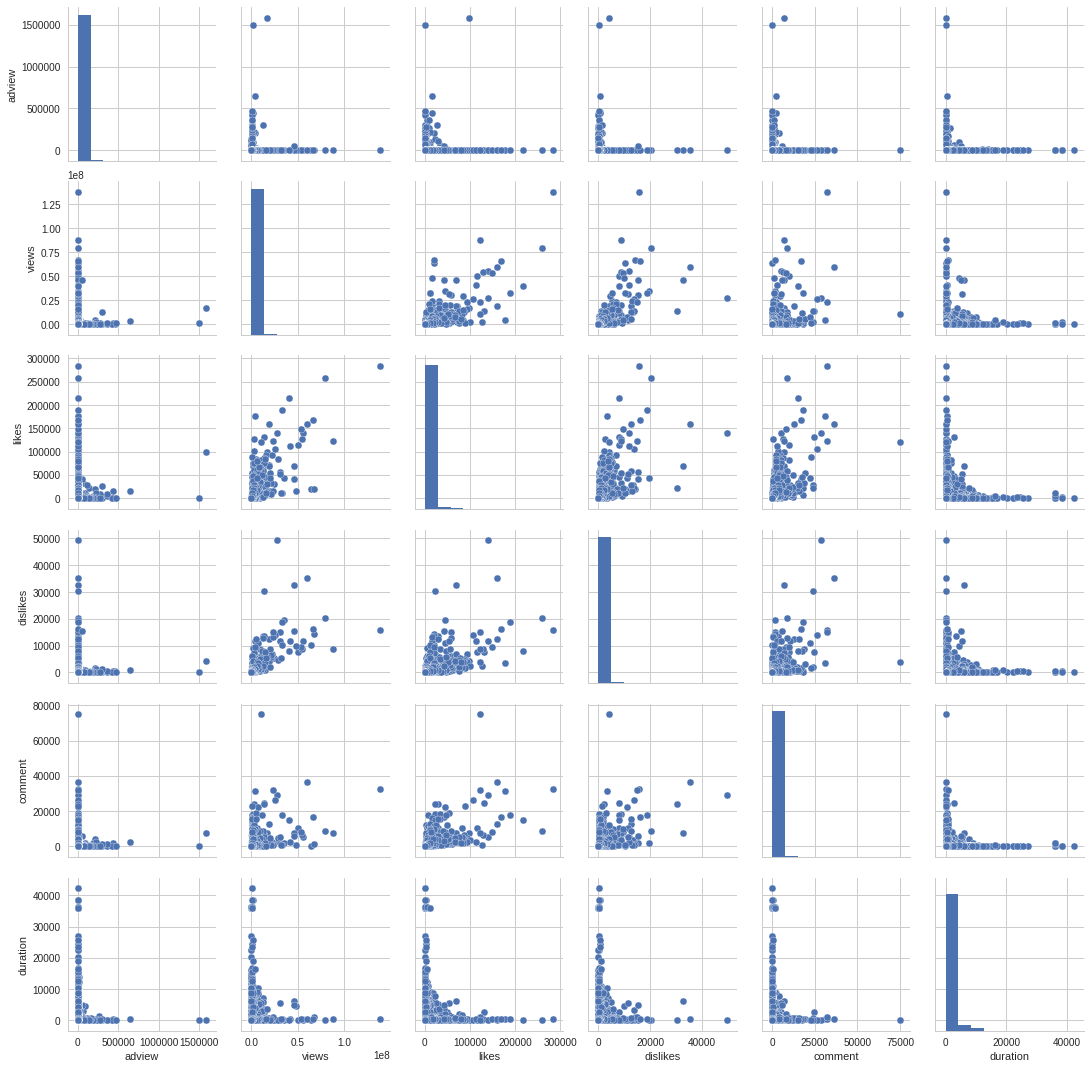

In [1392]:
sns.pairplot(train[columns])

std_scaler = preprocessing.StandardScaler()
std_scaler.fit(train[columns])
train[columns] = std_scaler.transform(train[columns])

for x in columns:
    #train[x] = np.log1p(train[x])
    temp = boxcox([train[x]]+1)[0]
    train[x] = temp

In [1433]:
train['adview'] = boxcox(train['adview'] + 1)[0]
train['views'] = boxcox(train['views'] + 1)[0]
train['likes'] = boxcox(train['likes']+ 1)[0]
train['dislikes'] = boxcox(train['dislikes']+ 1)[0]
train['comment'] = boxcox(train['comment']+ 1)[0]
train['duration'] = boxcox(train['duration']+ 1)[0]


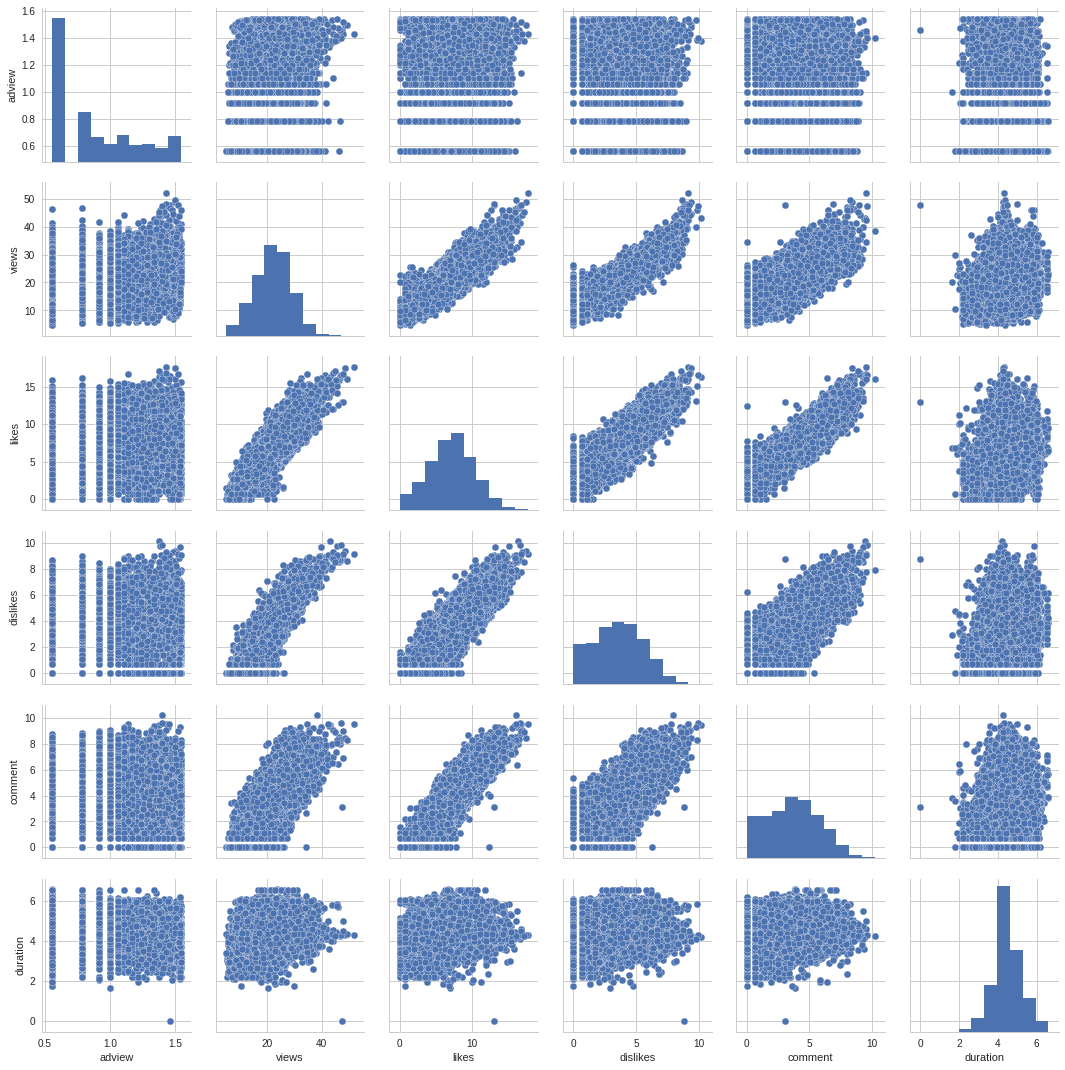

In [1434]:
sns.pairplot(train[columns])

In [1435]:
train.describe()

,adview,views,likes,dislikes,comment,duration,A,B,C,D,E,F,G,H,dayofweek,year,month
count,14633.000000,14633.000000,14633.000000,14633.000000,14633.000000,14633.000000,14633.000000,14633.000000,14633.000000,14633.000000,14633.000000,14633.000000,14633.000000,14633.000000,14633.000000,14633.000000,14633.000000
mean,0.861308,22.079595,7.126022,3.523407,3.655171,4.470598,0.024465,0.066220,0.037996,0.504476,0.109137,0.060070,0.168865,0.028771,2.778104,2014.436958,6.644024
std,0.324504,6.622217,3.054110,1.970107,2.103740,0.706413,0.154494,0.248675,0.191194,0.499997,0.311822,0.237624,0.374645,0.167167,1.905262,1.770415,3.291708
min,0.558337,4.739437,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2005.000000,1.000000
25%,0.558337,17.648227,5.048607,2.054468,2.043721,4.091483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2013.000000,4.000000
50%,0.785831,22.329631,7.180177,3.586519,3.728883,4.411444,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2015.000000,7.000000
75%,1.105643,26.653959,9.193855,4.968476,5.178191,4.845505,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2016.000000,9.000000
max,1.542381,52.018905,17.639858,10.156194,10.235611,6.598401,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,2017.000000,12.000000


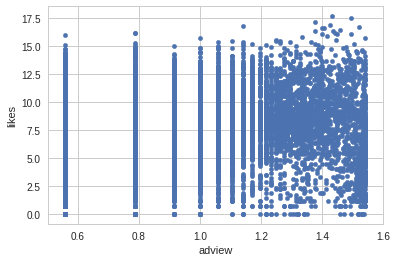

In [1436]:
train.plot(kind='scatter', x='adview', y='likes')

temp = train.loc[train.adview > 0.95]
train = train.loc[train.adview <= 0.95] 

In [1437]:
train.head()

,adview,views,likes,dislikes,comment,duration,A,B,C,D,E,F,G,H,dayofweek,year,month
0,1.403633,28.732600,11.523798,5.699239,6.605512,4.600568,0,0,0,0,0,1,0,0,2,2016,9
1,0.785831,10.828332,4.493782,1.091615,1.914607,4.719900,0,0,0,1,0,0,0,0,5,2016,10
2,0.558337,11.175766,3.546766,0.000000,1.088587,3.899531,0,0,1,0,0,0,0,0,5,2016,7
3,1.105643,26.881850,7.937209,4.939832,4.830758,4.288680,0,0,0,0,0,0,0,1,2,2016,7
4,0.558337,9.002234,0.705642,0.000000,0.000000,2.936318,0,0,0,1,0,0,0,0,2,2016,6


In [1439]:
train.year = train.year.values - 2005

In [1441]:
train['v_l_r'] = train['views'] / train['likes']
train['v_dur_r'] = train['views'] / train['duration']
train['l_dis_r'] = train['likes'] / train['dislikes']
train['l_dur_r'] = train['likes'] / train['duration']
train['l_dur_p'] = train['likes'] * train['duration']
train['v_dur_p'] = train['views'] * train['duration']
train['v_year_p'] = train['views'] * train['year']
train['l_year_p'] = train['likes'] * train['year']
diff = train['likes'] - train['dislikes']
train['diff_square'] = diff.pow(2)

In [1443]:
train['c_dur_r'] = train['comment'] / train['duration']
train['l_inv'] = 100 / train['likes']

In [1444]:
train.head()

,adview,views,likes,dislikes,comment,duration,A,B,C,D,...,v_dur_r,l_dis_r,l_dur_r,l_dur_p,v_dur_p,v_year_p,l_year_p,diff_square,c_dur_r,l_inv
0,1.403633,28.732600,11.523798,5.699239,6.605512,4.600568,0,0,0,0,...,6.245446,2.021989,2.504864,53.016015,132.186281,316.058603,126.761774,33.925485,1.435804,8.677695
1,0.785831,10.828332,4.493782,1.091615,1.914607,4.719900,0,0,0,1,...,2.294187,4.116635,0.952093,21.210202,51.108646,119.111653,49.431601,11.574738,0.405646,22.252971
2,0.558337,11.175766,3.546766,0.000000,1.088587,3.899531,0,0,1,0,...,2.865926,inf,0.909537,13.830724,43.580243,122.933430,39.014430,12.579552,0.279159,28.194696
3,1.105643,26.881850,7.937209,4.939832,4.830758,4.288680,0,0,0,0,...,6.268095,1.606777,1.850735,34.040147,115.287642,295.700350,87.309300,8.984269,1.126397,12.598887
4,0.558337,9.002234,0.705642,0.000000,0.000000,2.936318,0,0,0,1,...,3.065824,inf,0.240315,2.071988,26.433424,99.024577,7.762057,0.497930,0.000000,141.715006


In [1445]:
train = train.replace([np.inf, -np.inf], np.NaN)

In [1446]:
train.v_l_r.fillna(train.v_l_r.mean(), inplace=True)
train.v_dur_r.fillna(train.v_dur_r.mean(), inplace=True)
train.l_dis_r.fillna(train.l_dis_r.mean(), inplace=True)
train.l_dur_r.fillna(train.l_dur_r.mean(), inplace=True)
train.c_dur_r.fillna(train.c_dur_r.mean(), inplace=True)

In [1456]:
train.l_inv.fillna(train.l_inv.mean(), inplace=True)

In [1447]:
train['views_square'] = train.views.pow(2)

In [1448]:
train['views_sqrt'] = train.views.pow(0.5)

In [1449]:
train['views_permonth'] = train['views'] * train['month']

In [1450]:
train['comment_permon'] = train['comment'] * train['month']
train['likes_permon'] = train['likes'] * train['month']

In [1457]:
train.isnull().sum()

views             0
likes             0
dislikes          0
comment           0
duration          0
A                 0
B                 0
C                 0
D                 0
E                 0
F                 0
G                 0
H                 0
dayofweek         0
year              0
month             0
v_l_r             0
v_dur_r           0
l_dis_r           0
l_dur_r           0
l_dur_p           0
v_dur_p           0
v_year_p          0
l_year_p          0
diff_square       0
c_dur_r           0
l_inv             0
views_square      0
views_sqrt        0
views_permonth    0
comment_permon    0
likes_permon      0
dtype: int64

train.loc[train.adview > 12] = train.adview.mean()

In [1451]:
train_y = train['adview']
train = train.drop(['adview'], axis = 1)

Random Forests
MAE : 0.129314
RMSE : 0.157106
Auc: 0.701689
R2: 0.251153


model_score 0.906490346166


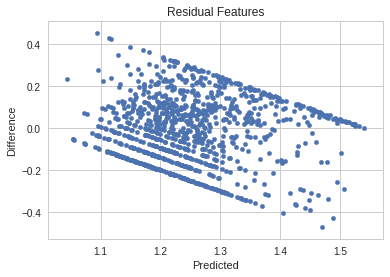

In [456]:
def display_metrics(y_test, y_pred):
    print ("MAE : %f" % metrics.mean_absolute_error(y_test, y_pred))
    print ("RMSE : %f" % np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    #print ("NRMSE : %f" % np.mean(np.abs((y_test - y_pred)/y_test)) * 100)
    print ("Auc: %f" % metrics.auc(y_test, y_pred,reorder=True))
    print ("R2: %f" % metrics.r2_score(y_test, y_pred))
    #print ("fbeta: %f" % metrics.fbeta_score(y_test, y_pred, beta=2))
    print ("\n")
           
def model_train(model,X,y):
    # Split test, train
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state = 1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    display_metrics(y_test, y_pred)
    
    print ('model_score', model.score(X_train, y_train))
    
    plt.figure(figsize= (50,10))
    preds = pd.DataFrame({"Predicted":model.predict(X_test), "true":y_test})
    preds["Difference"] = preds["true"] - preds["Predicted"]
    preds.plot(x = "Predicted", y = "Difference",kind = "scatter", title = "Residual Features")
    plt.show()
    
def training(X,y):   
    
    
    #Random Forests
    rand_clf = RandomForestRegressor(n_jobs=-1, bootstrap=True, n_estimators = 300)
    print ("Random Forests")
    model_train(rand_clf, X, y)

    #Ridge Regression
#    ridge_clf = Ridge(alpha=0.001, normalize=True)
#    print ("Ridge Regression")
#    model_train(ridge_clf, X, y)
    
    #Lasso Regression
#    lasso_clf = Lasso(alpha=0.001, normalize=True)
#    print ("Lasso Regression")
#    model_train(lasso_clf, X, y)
    
    #MLP Regression
#    mlp_clf = MLPRegressor(solver = 'lbfgs', alpha = 0.01, hidden_layer_sizes=(10,10), random_state= 1)
#    print ("MLP (NN)")
#    model_train(mlp_clf, X, y)
    
    
    return rand_clf

rand_reg = training(train, train_y)


rf = RandomForestRegressor(n_jobs=-1, bootstrap=True, n_estimators=300)
scores = []
for i in range(train.shape[1]):
    score = cross_val_score(rf, train.iloc[:, i:i+1], y_train, scoring="r2",
                              cv=3)
    scores.append((round(np.mean(score), 3)))
print (scores)

In [1458]:
X_train, X_test, y_train, y_test = train_test_split(train,train_y,test_size=0.2, random_state = 7)

In [1459]:
random_forest = RandomForestRegressor(n_jobs=-1, bootstrap=True, n_estimators=40)

rfe = RFE(random_forest, n_features_to_select=1)

rfe.fit(train, train_y)

print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), train.columns)))

In [1460]:
random_forest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [1461]:
y_pred = random_forest.predict(X_test)

In [1462]:
random_forest.score(X_train, y_train)

0.88608235679077774

In [1463]:
random_forest.score(X_test,y_test)

0.2315896776320896

In [1464]:
# get Correlation Coefficient for each feature
coeff_df = DataFrame(X_train.columns)
coeff_df.columns = ['Features']
coeff_df["Coefficient Estimate"] = pd.Series(random_forest.feature_importances_)

# preview
coeff_df

,Features,Coefficient Estimate
0,views,0.048528
1,likes,0.014610
2,dislikes,0.039979
3,comment,0.027926
4,duration,0.049792
5,A,0.004242
6,B,0.005601
7,C,0.002189
8,D,0.007836
9,E,0.005219


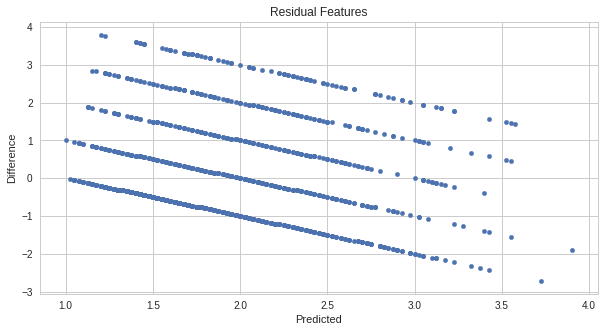

In [1363]:
#Remaining Feature Set
plt.figure(figsize= (50,10))
preds = pd.DataFrame({"Predicted":random_forest.predict(X_test), "true":y_test})
preds["Difference"] = preds["true"] - preds["Predicted"]
preds.plot(x = "Predicted", y = "Difference",kind = "scatter", title = "Residual Features",figsize=(10,5))

In [567]:
y_test.loc[y_test > 600000]

1742    1333626
1884     991819
1198     704516
Name: adview, dtype: int64

In [568]:
preds.loc[preds.true > 60000]

,Predicted,true,Difference
4297,71.093333,130501,1.304299e+05
1742,260867.993333,1333626,1.072758e+06
8263,281869.346667,421246,1.393767e+05
234,870.033333,92782,9.191197e+04
14918,10303.076667,60204,4.990092e+04
1884,48052.693333,991819,9.437663e+05
11439,21984.510000,114055,9.207049e+04
1198,61.710000,704516,7.044543e+05
134,13655.223333,68944,5.528878e+04
14266,16614.936667,165271,1.486561e+05


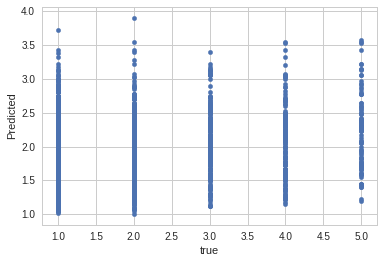

In [1364]:
preds.plot(kind='scatter', x='true', y='Predicted')

In [76]:
rlasso = RandomizedLasso(alpha=0.025)

In [77]:
rlasso.fit(train, train_y)

RandomizedLasso(alpha=0.025, eps=2.2204460492503131e-16, fit_intercept=True,
        max_iter=500, memory=Memory(cachedir=None), n_jobs=1,
        n_resampling=200, normalize=True, pre_dispatch='3*n_jobs',
        precompute='auto', random_state=None, sample_fraction=0.75,
        scaling=0.5, selection_threshold=0.25, verbose=False)

In [79]:
print (sorted(zip(map(lambda x: round(x, 4), rlasso.scores_), 
                 train.columns), reverse=True))

[(0.0, 'year'), (0.0, 'views_square'), (0.0, 'views_sqrt'), (0.0, 'views_permonth'), (0.0, 'views'), (0.0, 'v_l_r'), (0.0, 'v_dur_r'), (0.0, 'v_dur_p'), (0.0, 'month'), (0.0, 'likes'), (0.0, 'l_dur_r'), (0.0, 'l_dur_p'), (0.0, 'l_dis_r'), (0.0, 'duration'), (0.0, 'dislikes'), (0.0, 'dayofweek'), (0.0, 'comment'), (0.0, 'H'), (0.0, 'G'), (0.0, 'F'), (0.0, 'E'), (0.0, 'D'), (0.0, 'C'), (0.0, 'B'), (0.0, 'A')]


In [82]:
mine = MINE()
mic_scores = []
for i in range(train.shape[1]):
    mine.compute_score(train.iloc[:,i], train_y)
    m = mine.mic()
    mic_scores.append(m)

In [86]:
print (sorted(zip(mic_scores, train.columns),reverse=True))

[(0.11449266491930599, 'views_square'), (0.11449266491930599, 'views_sqrt'), (0.11449266491930599, 'views'), (0.09989441392499666, 'dislikes'), (0.07919194628136983, 'likes'), (0.0784375527414729, 'l_dis_r'), (0.0783142800114633, 'l_dur_p'), (0.07732382217001729, 'v_dur_p'), (0.07575273433519517, 'l_dur_r'), (0.075729139055869, 'v_dur_r'), (0.06471073965077961, 'v_l_r'), (0.06399579741368099, 'comment'), (0.06348123054117873, 'views_permonth'), (0.052722506658366815, 'year'), (0.042097766947722916, 'duration'), (0.037244565697785635, 'D'), (0.035249893543062044, 'G'), (0.03433694774103084, 'month'), (0.03155135250017935, 'F'), (0.03090919424685683, 'dayofweek'), (0.029052889713027497, 'E'), (0.02819688129699216, 'B'), (0.02061718811583538, 'A'), (0.014307010006821181, 'C'), (0.01086283201911779, 'H')]


In [87]:
train.columns

Index(['views', 'likes', 'dislikes', 'comment', 'duration', 'A', 'B', 'C', 'D',
       'E', 'F', 'G', 'H', 'dayofweek', 'year', 'month', 'v_l_r', 'v_dur_r',
       'l_dis_r', 'l_dur_r', 'l_dur_p', 'v_dur_p', 'views_square',
       'views_sqrt', 'views_permonth'],
      dtype='object')

In [88]:
columns = ['views', 'likes', 'dislikes', 'comment', 'duration',
        'F', 'G', 'year', 'month', 'v_l_r', 'v_dur_r',
       'l_dis_r', 'l_dur_r', 'l_dur_p', 'v_dur_p', 'views_square',
       'views_sqrt', 'views_permonth']

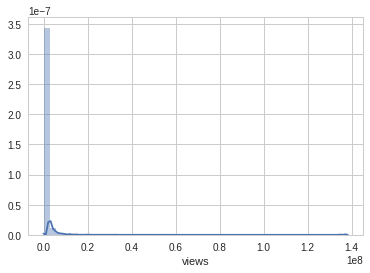

In [224]:
sns.distplot(train['views'])

In [226]:
x = boxcox(train['views'])[0]
train['views'] = x

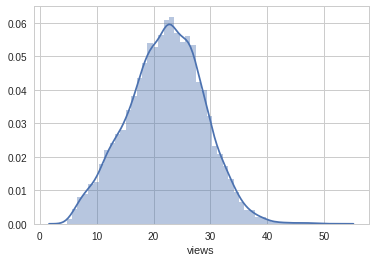

In [322]:
sns.distplot(train['views'])

In [92]:
X_train, X_test, y_train, y_test = train_test_split(train,train_y,test_size=0.2, random_state = 1)

In [93]:
rf = RandomForestRegressor(n_jobs=-1, bootstrap=True, n_estimators=300)

In [94]:
rf.fit(X_train[columns], y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [95]:
rf.score(X_train[columns], y_train)

0.89461318439557347

In [97]:
rf.score(X_test[columns], y_test)

0.26879815552417985

In [1465]:
est = GradientBoostingRegressor(n_estimators=250, learning_rate=0.1, random_state=7, max_depth=5)

In [1466]:
est.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=250,
             presort='auto', random_state=7, subsample=1.0, verbose=0,
             warm_start=False)

In [1467]:
est.score(X_test, y_test)

0.22828708383490737

In [1468]:
est.score(X_train, y_train)

0.54884305253615007

In [1469]:
print (sorted(zip(est.feature_importances_, train.columns),reverse=True))

[(0.07662896804672778, 'v_year_p'), (0.071173963243272173, 'v_l_r'), (0.065741814989131897, 'l_dis_r'), (0.05943139195032069, 'views_permonth'), (0.055268403701706957, 'duration'), (0.051479419774959345, 'v_dur_r'), (0.048153806948935327, 'c_dur_r'), (0.047197190020498068, 'v_dur_p'), (0.045558176716092476, 'l_dur_p'), (0.043878279771734877, 'year'), (0.041692155346983589, 'diff_square'), (0.041543189993694801, 'likes_permon'), (0.039142310557115721, 'comment_permon'), (0.036132779830080973, 'dislikes'), (0.034482922783568161, 'l_year_p'), (0.032438518192817789, 'l_dur_r'), (0.028279893844603755, 'comment'), (0.024246051064655397, 'views'), (0.023554261304980683, 'views_sqrt'), (0.020095026106915288, 'l_inv'), (0.019542733316736564, 'month'), (0.019232804784889836, 'dayofweek'), (0.018876255706943384, 'views_square'), (0.015217317839423684, 'likes'), (0.0081967169996932689, 'G'), (0.0076518757319922479, 'D'), (0.0058140749302471898, 'F'), (0.0054074283251093393, 'E'), (0.00436165295970

In [328]:
X_train.columns

Index(['views', 'likes', 'dislikes', 'comment', 'duration', 'A', 'B', 'C', 'D',
       'E', 'F', 'G', 'H', 'dayofweek', 'year', 'month', 'v_l_r', 'v_dur_r',
       'l_dis_r', 'l_dur_r', 'l_dur_p', 'v_dur_p', 'views_square',
       'views_sqrt', 'views_permonth'],
      dtype='object')

# Classification - 

In [1312]:
from sklearn.ensemble import RandomForestClassifier

In [1313]:
X_train, X_test, y_train, y_test = train_test_split(train,train_y,test_size=0.2, random_state = 6)

In [1314]:
rf = RandomForestClassifier(max_features='auto')

In [1320]:
params = { "criterion" : ["entropy"]
              , "min_samples_leaf" : [5, 7, 10]
              , "min_samples_split" : [ 3, 5, 8]
              , "n_estimators": [ 100, 120]
         }
GS = GridSearchCV(estimator=rf, param_grid=params, cv=5,n_jobs=-1)
GS= GS.fit(X_train,y_train)
print(GS.best_score_)
print(GS.best_params_)

0.584611808461
{'criterion': 'entropy', 'min_samples_leaf': 10, 'min_samples_split': 8, 'n_estimators': 120}


In [1319]:
#{'criterion': 'entropy', 'min_samples_leaf': 7, 'min_samples_split': 5, 'n_estimators': 100}

In [1321]:
GS.score(X_train, y_train)

0.62691771269177132

In [1322]:
GS.score(X_test, y_test)

0.56159925615992556

In [1323]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [1324]:
rf.score(X_train, y_train)

0.97419804741980476

In [1325]:
rf.score(X_test, y_test)

0.52487215248721519

In [1330]:
#Remaining Feature Set
plt.figure(figsize= (50,10))
preds = pd.DataFrame({"Predicted":rf.predict(X_test), "true":y_test})
temp = preds.loc[preds.Predicted == preds.true]

In [1331]:
temp.true.value_counts()

1    1063
2      49
4       9
3       5
5       3
Name: true, dtype: int64

In [1332]:
temp1 = preds.loc[preds.Predicted != preds.true]

In [1333]:
print (temp1.true.value_counts())
print (temp1.Predicted.value_counts())

2    408
3    205
1    156
4    151
5    102
Name: true, dtype: int64
1    740
2    176
3     62
4     32
5     12
Name: Predicted, dtype: int64


In [778]:
preds.true.value_counts()

01       1235
12        441
24        363
20k       239
46        188
610       165
1020      162
1020K     103
20k>       32
Name: true, dtype: int64

In [779]:
rf.feature_importances_

array([ 0.06407403,  0.05175209,  0.05324867,  0.05117148,  0.05345285,
        0.00050005,  0.00357839,  0.00112765,  0.01278795,  0.00357091,
        0.00238958,  0.0052663 ,  0.00055767,  0.02920758,  0.07474184,
        0.04120719,  0.05537233,  0.05871838,  0.05336774,  0.05494511,
        0.05435355,  0.06701435,  0.06860606,  0.07256579,  0.06642245])

### Random forest regressor with grid search

In [1470]:
X_train, X_test, y_train, y_test = train_test_split(train,train_y,test_size=0.2, random_state = 5)

In [1471]:
rf = RandomForestRegressor(max_features='auto')
    #min_samples_leaf= 5, min_samples_split = 15, n_estimators= 50, max_features='auto'
# n-estimators = 50, min_samples_split = 10

In [1476]:
params = { #"criterion" : ["gini", "entropy"]
               "min_samples_leaf" : [2, 3]
              , "min_samples_split" : [3, 5, 7]
              , "n_estimators": [ 250, 300, 350]
         }
GS = GridSearchCV(estimator=rf, param_grid=params, cv=5,n_jobs=-1)
GS= GS.fit(X_train,y_train)
print(GS.best_score_)
print(GS.best_params_)

KeyboardInterrupt: 

In [1408]:
#Adview outlier removed = 40% on test set + two rows removed (1742, 1884)
#{'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 120} 
#with boxcox transformation 
##############################################
#Adview + view outlier decreased the accuracy

In [1473]:
GS.score(X_test, y_test)

0.24609663941878698

In [1474]:
GS.score(X_train, y_train)

0.78614450191695484

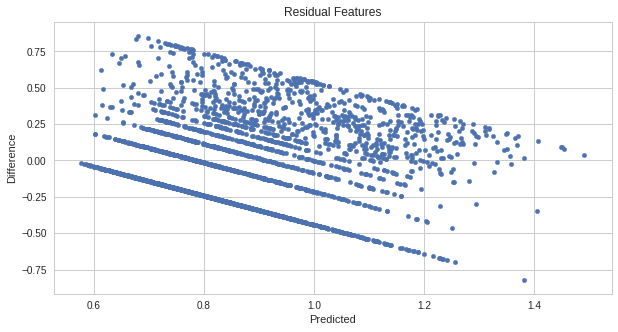

In [1475]:
#Remaining Feature Set
plt.figure(figsize= (50,10))
preds = pd.DataFrame({"Predicted":GS.predict(X_test), "true":y_test})
preds["Difference"] = preds["true"] - preds["Predicted"]
preds.plot(x = "Predicted", y = "Difference",kind = "scatter", title = "Residual Features",figsize=(10,5))

In [1013]:
preds.loc[preds.Difference > 200000]

,Predicted,true,Difference
1060,49107.399241,453147,404039.600759
4279,5833.821734,207712,201878.178266
9142,3618.594641,360231,356612.405359
2173,176324.899555,427809,251484.100445


In [1100]:
rf = RandomForestRegressor(max_features='auto', min_samples_leaf=13, min_samples_split= 2, n_estimators = 40)

In [1116]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=13,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=40, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [1117]:
rf.score(X_train, y_train)

0.17750694612663567

In [1118]:
rf.score(X_test, y_test)

0.31897918550172122